## 6-3. Excited state search method (subspace-search variational quantum eigensolver)

As explained in [chapter 5-1](5.1_variational_quantum_eigensolver.ipynb), variational quantum eigensolver (VQE) is an algorithm for exploring the **ground state** of a quantum system. The ground state is an important state that determines the properties of various materials. There are phenomena such as photoresponse that are difficult to describe without using **excited states**.

Therefore, algorithms for creating excited-state wavefunctions on quantum computers are also being actively researched. Among them, I would like to introduce a new method proposed in 2018, Subspace-Search VQE (SSVQE) [1].

### Algorithm

procedures of SSVQE are shown below.

1. Prepare $k$ initial states $\{|\varphi_i\rangle\}_{i=0}^{k-1}$ that are orthogonal to each other.
2. For each of them, apply a suitable quantum circuit $U(\theta)$ to generate the trial state $\{|\psi_i(\theta)\rangle \}_{i=0}^{k-1}$  (Note: $|\psi_i(\theta)\rangle = U(\theta)|\varphi_i\rangle$)
3. Tune $\theta$ to minimize the cost function $L(\theta) = \sum_i w_i \langle\psi_i(\theta)|H|\psi_i(\theta)\rangle$. where $w_i$ is chosen to be positive and $w_i<w_j$ for $i>j$.

When $U(\theta)$ has sufficient expressive power, $|\psi_i\rangle$ becomes the $i$-th excited state in converged $\theta$. This is because the global minimum point of the cost function is $|\psi_i\rangle = |E_i\rangle$, where $|E_i\rangle$ is the $i$-th excited state of the Hamiltonian. (See the original paper [1] for details.)

Below is an example of simulating SSVQE using QURI Parts.

### SSVQE implementation

Implement SSVQE to search the ground state and the first excited state of the hydrogen molecule. If we treat the hydrogen molecule with the `sto-3g` minimal basis set, we get a 4 qubit Hamiltonian. Therefore, assuming the mutually orthogonal initial states $\{|\varphi_i\rangle\}_{i=0}^{1}$ required for SSVQE, we use one qubit flipped $|0000\rangle$ and $|0001\rangle$ .

* Note for those familiar with quantum chemistry: the first excited state here refers to the first excited state of the Hamiltonian of the hydrogen molecule without considering the number of electrons, which in chemical terms is the ground state of the hydrogen molecule ion.

#### Preparation of Hamiltonian

The Hamiltonian is calculated by `quri_parts.pyscf` + `quri_parts.openfermion` in the same procedure as last time. However, since excited states are also a problem in SSVQE, use `scipy.sparse.linalg.eigsh` to obtain the exact solution of the excited state.

In [1]:
from pyscf import gto, scf
from quri_parts.pyscf.mol import get_spin_mo_integrals_from_mole
from quri_parts.openfermion.mol import get_qubit_mapped_hamiltonian
from quri_parts.core.operator import get_sparse_matrix
from scipy.sparse.linalg import eigsh

# Create the electron integrals and Hamiltonian
distance  = 0.977
mole = gto.M(
    atom=[["H", [0,0,0]],["H", [0,0,distance]]],
    spin=0,
    charge=0,
    basis="sto-3g"
)
mf = scf.RHF(mole).run(verbose=0)

full_space, mo_eints = get_spin_mo_integrals_from_mole(mole, mf.mo_coeff)
jw_hamiltonian, _, _ = get_qubit_mapped_hamiltonian(full_space, mo_eints)

# Compute the ground state and 1st excited state energy by exact diagonalization.
hamiltonian_matrix = get_sparse_matrix(jw_hamiltonian)
eigval, eigvec = eigsh(hamiltonian_matrix, k=2, which="SA") 

### Compose ansatz

Here we use the Hardware Efficient ansatz that is already built into QURI Parts. The quantum circuits were modeled after those used in experiments with superconducting qubits (A. Kandala _et. al._ , “Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets“, Nature **549**, 242–246).

In [2]:
from quri_parts.algo.ansatz import HardwareEfficient
from quri_parts.openfermion.transforms import jordan_wigner

n_qubit = jordan_wigner.n_qubits_required(full_space.n_active_orb*2)
depth = n_qubit

def he_ansatz_circuit(n_qubit: int, depth: int) -> HardwareEfficient:
    return HardwareEfficient(n_qubit, depth)

#### define cost function of SSVQE

In [3]:
from typing import Sequence
import numpy as np
from quri_parts.algo.ansatz import HardwareEfficient
from quri_parts.core.state import ComputationalBasisState
from quri_parts.qulacs.estimator import (
    create_qulacs_vector_estimator, 
    create_qulacs_vector_concurrent_parametric_estimator
)

from quri_parts.core.state import ParametricCircuitQuantumState
from quri_parts.core.estimator.gradient import create_numerical_gradient_estimator
from quri_parts.circuit import X

from quri_parts.core.utils.recording import recordable, Recorder

estimator = create_qulacs_vector_estimator()

@recordable
def cost(recorder: Recorder, theta_list: list[float]) -> float:
    """Cost function to be optimized in the SSVQE procedure.
    """
    ansatz_circuit = he_ansatz_circuit(n_qubit, depth)
    state_0 = ComputationalBasisState(
        n_qubit, bits=0
    ).with_gates_applied(ansatz_circuit.bind_parameters(theta_list))
    state_1 = ComputationalBasisState(
        n_qubit, bits=1
    ).with_gates_applied(ansatz_circuit.bind_parameters(theta_list))

    est_1 = estimator(jw_hamiltonian, state_0).value.real 
    est_2 = estimator(jw_hamiltonian, state_1).value.real

    recorder.info("est_1", est_1)
    recorder.info("est_2", est_2)
    
    return est_1 + 0.5 * est_2


def grad_func(theta_list: Sequence[float]) -> Sequence[float]:
    """Gradient of the cost function with respect to the circuit parameters
    theta.
    """
    param_estimator = create_qulacs_vector_concurrent_parametric_estimator()
    grad_estimator = create_numerical_gradient_estimator(param_estimator, 1e-4)
    
    ansatz_circuit = HardwareEfficient(n_qubit, depth)
    state_0 = ParametricCircuitQuantumState(n_qubit, ansatz_circuit)
    
    ansatz_circuit_1 = ansatz_circuit.get_mutable_copy()
    ansatz_circuit_1.add_gate(X(0), 0)
    state_1 = ParametricCircuitQuantumState(n_qubit, ansatz_circuit_1)

    grad_0 = np.array(grad_estimator(jw_hamiltonian, state_0, theta_list).values).real
    grad_1 = np.array(grad_estimator(jw_hamiltonian, state_1, theta_list).values).real

    return grad_0 + grad_1 * 0.5 

init_theta_list = np.random.random(2*n_qubit*(depth+1))*1e-1
cost(init_theta_list)

0.2047844255126149

#### Execution of SSVQE

Now that we're ready, let's run SSVQE. For optimization, the BFGS method implemented in scipy is used, and the initial parameters are randomly selected. It should finish in tens of seconds.

In [4]:
from scipy.optimize import minimize
import numpy as np

from quri_parts.core.utils.recording import RecordSession, INFO

# Ansatz and optimization parameters
ansatz_circuit = HardwareEfficient(n_qubit, depth)
init_theta_list = np.random.random(ansatz_circuit.parameter_count)*1e-1
method = "BFGS"
options = {"disp": True, "maxiter": 50, "gtol": 1e-6}


# Run SSVQE and record the hamiltonian expectation values
# of the 2 orthogonal states while the optimization loop is executed.
recoder_session = RecordSession()
recoder_session.set_level(INFO, cost)

with recoder_session.start():
    opt = minimize(cost, init_theta_list, jac=grad_func, method=method)

In [5]:
def get_history(session: RecordSession) -> tuple[list[float], list[float]]:
    """Retrieve hamiltonian expectation value from recording session.
    """
    exp_history_0 = []
    exp_history_1 = []
    for group in session.get_records().get_history(cost):
        entries = group.entries
        exp_history_0.append(entries[0].data[1])
        exp_history_1.append(entries[1].data[1])
    return exp_history_0, exp_history_1

exp_history_0, exp_history_1 = get_history(recoder_session)

Plotting the execution result, we can see that it has converged to the correct solution.

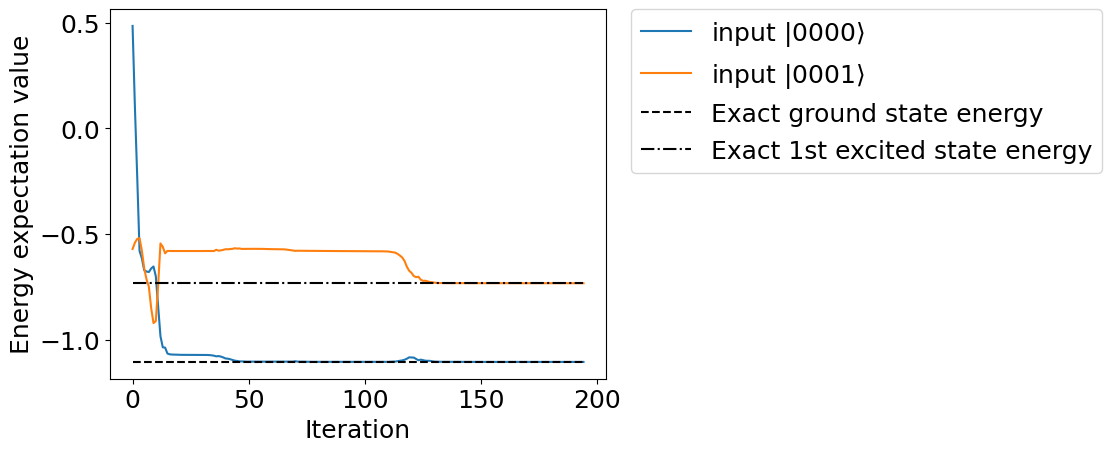

In [6]:
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 18
plt.plot(exp_history_0, label=r"input $|0000\rangle$")
plt.plot(exp_history_1, label=r"input $|0001\rangle$")
plt.plot(range(len(exp_history_0)), [eigval[0]]*len(exp_history_0), linestyle="dashed", color="black", label="Exact ground state energy")
plt.plot(range(len(exp_history_1)), [eigval[1]]*len(exp_history_1), linestyle="-.", color="black", label="Exact 1st excited state energy")
plt.xlabel("Iteration")
plt.ylabel("Energy expectation value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.show()

##### VQE using QURI Parts

As explained in the Quantum Circuit Learning chapter, we can use QURI Parts instead of scipy to perform our optimization procedure. Here, we deomonstrate how to do VQE with QURI Parts.

In [7]:
from typing import Callable, Sequence
from quri_parts.algo.optimizer import OptimizerStatus, OptimizerState, Optimizer

def vqe(
    init_params: Sequence[float],
    cost_fn: Callable[[Sequence[float]], float],
    grad_fn: Callable[[Sequence[float]], Sequence[float]],
    optimizer: Optimizer,
) -> OptimizerState:
    """Optimization loop for performing VQE.
    """
    opt_state = optimizer.get_init_state(init_params)
    
    while True:
        opt_state = optimizer.step(opt_state, cost_fn, grad_fn)
        
        if opt_state.status == OptimizerStatus.FAILED:
            print("Optimizer failed")
            break
        if opt_state.status == OptimizerStatus.CONVERGED:
            print("Optimizer converged")
            break
    return opt_state

In [8]:
from quri_parts.algo.optimizer import LBFGS

record_session = RecordSession()
record_session.set_level(INFO, cost)

with record_session.start():
    result_qp = vqe(init_theta_list, cost, grad_func, LBFGS())

Optimizer converged


In [9]:
qp_exp_history0, qp_exp_history1 = get_history(record_session)

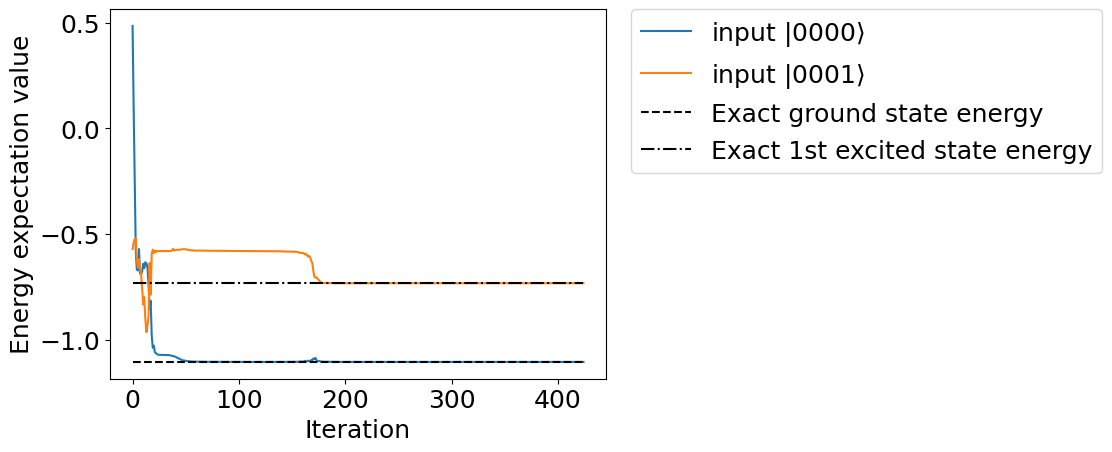

In [10]:
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 18
plt.plot(qp_exp_history0, label=r"input $|0000\rangle$")
plt.plot(qp_exp_history1, label=r"input $|0001\rangle$")
plt.plot(range(len(qp_exp_history0)), [eigval[0]]*len(qp_exp_history0), linestyle="dashed", color="black", label="Exact ground state energy")
plt.plot(range(len(qp_exp_history1)), [eigval[1]]*len(qp_exp_history1), linestyle="-.", color="black", label="Exact 1st excited state energy")
plt.xlabel("Iteration")
plt.ylabel("Energy expectation value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.show()

### Reference
[1] K. M Nakanishi, K. Mitarai, and K. Fujii, “Subspace-search variational quantum eigensolver for excited states”, Phys. Rev. Research 1, 033062 (2019),  https://arxiv.org/abs/1810.09434